## Model Training on Full Game Stats

In [17]:
import json
import pandas as pd

pd.set_option('display.max_columns', None)

### Load Dataset

In [2]:
df = pd.read_csv('../data/preprocessed/stats_salaries.csv')
df

FGM   FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  \
0       4.0  10.0   0.400   3.0   8.0    0.375  4.0  4.0   1.000   0.0   8.0   
1       9.0  19.0   0.474   4.0  11.0    0.364  3.0  3.0   1.000   0.0   3.0   
2       7.0  15.0   0.467   2.0   8.0    0.250  0.0  0.0   0.000   0.0   1.0   
3       7.0  13.0   0.538   1.0   5.0    0.200  2.0  2.0   1.000   2.0   2.0   
4       5.0  13.0   0.385   1.0   6.0    0.167  4.0  6.0   0.667   1.0   2.0   
...     ...   ...     ...   ...   ...      ...  ...  ...     ...   ...   ...   
492307  1.0   1.0   1.000   0.0   0.0    0.000  0.0  0.0   0.000   0.0   0.0   
492308  0.0   1.0   0.000   0.0   0.0    0.000  0.0  0.0   0.000   0.0   1.0   
492309  0.0   1.0   0.000   0.0   1.0    0.000  0.0  0.0   0.000   0.0   2.0   
492310  2.0   3.0   0.667   0.0   0.0    0.000  1.0  2.0   0.500   1.0   9.0   
492311  1.0   1.0   1.000   0.0   0.0    0.000  2.0  2.0   1.000   1.0   1.0   

         REB  AST  STL  BLK   TO   PF   PTS  PLUS_MINUS  WON_GAME  \
0        8.0  5.0  3.0  1.0  1.0  1.0  15.0         5.0         1   
1        3.0  5.0  1.0  0.0  0.0  3.0  25.0        -3.0         0   
2        1.0  3.0  2.0  1.0  4.0  2.0  16.0         7.0         1   
3        4.0  4.0  4.0  0.0  4.0  5.0  17.0         7.0         1   
4        3.0  5.0  1.0  1.0  2.0  3.0  15.0       -21.0         0   
...      ...  ...  ...  ...  ...  ...   ...         ...       ...   
492307   0.0  0.0  0.0  0.0  1.0  0.0   2.0        -7.0         1   
492308   1.0  0.0  0.0  0.0  0.0  2.0   0.0       -10.0         0   
492309   2.0  0.0  0.0  0.0  2.0  2.0   0.0        -1.0         0   
492310  10.0  0.0  0.0  2.0  2.0  3.0   5.0       -12.0         0   
492311   2.0  0.0  1.0  0.0  0.0  2.0   4.0        10.0         0   

        SECS_PLAYED  C  F  G  Atlanta Hawks  Boston Celtics  Brooklyn Nets  \
0              2182  0  1  0              0               0              0   
1              2067  0  1  0              0               0              0   
2              1529  0  1  0              0               0              0   
3              1942  0  1  0              0               0              0   
4              2266  0  1  0              0               0              0   
...             ... .. .. ..            ...             ...            ...   
492307          189  0  0  0              0               0              1   
492308          510  0  0  0              0               0              0   
492309          709  0  0  0              0               0              0   
492310         1255  0  0  0              0               0              0   
492311          474  0  0  0              0               0              0   

        Charlotte Hornets  Chicago Bulls  Cleveland Cavaliers  \
0                       0              0                    0   
1                       0              0                    0   
2                       0              0                    0   
3                       0              0                    0   
4                       0              0                    0   
...                   ...            ...                  ...   
492307                  0              0                    0   
492308                  0              0                    0   
492309                  0              0                    0   
492310                  0              0                    0   
492311                  0              0                    0   

        Dallas Mavericks  Denver Nuggets  Detroit Pistons  \
0                      0               0                0   
1                      0               0                0   
2                      0               0                0   
3                      0               0                0   
4                      0               0                0   
...                  ...             ...              ...   
492307                 0               0                0   
492308      

### Train-Test Split
To start off, we will construct a train-test split:

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['INFLATION_ADJ_SALARY'])
y = df['INFLATION_ADJ_SALARY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Base model
We construct a base model to compare model results against. This will just output the mean every time.

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = [y_train.mean()] * len(y_test)
print("Name: Base Model (Mean)")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

Name: Base Model (Mean)
MAE: 5517712.382289887
MSE: 53091746044291.516
RMSE: 7286408.308919527
R2: -5.393104326234521e-06


### Data Scaling

We scale/normalize the data to perform better on different types of models. The resultant `preprocessor` will be used in the model pipelines.

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

ss_columns = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
              'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS', 'SECS_PLAYED']
mm_columns = ['YEARS_SINCE_2003']  # uniform distribution; not normal distribution

preprocessor = ColumnTransformer([
    ('standard', StandardScaler(), ss_columns),
    ('minmax', MinMaxScaler(), mm_columns),
], remainder='passthrough')  # note: order of columns is ss_columns + mm_columns + remainder cols
scaled_X_train = preprocessor.fit_transform(X_train)

### Hyperparameter Optimization: Test different models on sample

We test different models on a subsample of the dataset to get the best hyperparameters and remove certain features. This will help speed up training.

In [5]:
X_sample = scaled_X_train.sample(20000, random_state=101) # minimum for statistically significant result
y_sample = y_train[X_sample.index]

In [6]:
from sklearn.experimental import enable_halving_search_cv # enable halving grid search

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import HalvingGridSearchCV

In [9]:
hyperparameters = {
    'Linear': {
        'fit_intercept': [True, False],
    },
    'Ridge': {
        'fit_intercept': [True, False],
        'alpha': [1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1],
    },
    'Lasso': {
        'fit_intercept': [True, False],
        'alpha': [1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1],
        'precompute': [True, False],
        'selection': ['cyclic', 'random'],
    },
    'KNN': {
        'n_neighbors': [4, 6, 8, 10, 15, 20],
        'leaf_size': list(range(20, 40, 2)),
        'p': [1, 2],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'chebyshev'],
    },
    'SGD': {
        'fit_intercept': [True, False],
        'loss': ['squared_error', 'huber'],
        'penalty': ['l1', 'l2'],
        'alpha': [1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1],
        'learning_rate': ['optimal', 'invscaling', 'adaptive'],
        'shuffle': [True, False],
        'average': [True, False],
        'max_iter': [1000, 5000, 15000]
    },
    'SVR': {
        'epsilon': [0, 0.1, 0.2, 0.3, 0.5],
        'intercept_scaling': [0.5, 1, 2, 3, 5],
        'fit_intercept': [True, False],
        'C': [0.1, 0.5, 1, 5, 10]
    },
    'RF': {
        'bootstrap': [True, False],
        'max_depth': [10, 50, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [10, 50, 100, 200, 400, 600],
    },
    'AB': {
        'base_estimator': [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=10),
                           DecisionTreeRegressor(max_depth=100), DecisionTreeRegressor(max_depth=None)],
        'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5, 0.8, 1, 1.5, 2],
        'loss': ['linear', 'square'],
        'n_estimators': [10, 50, 100, 200, 400, 600],
    },
    'GB': {
        'loss': ['squared_error', 'absolute_error'],
        'learning_rate': [1e-4, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1],
        'max_depth': [10, 50, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [10, 50, 100, 200, 400, 600],
    }
}

In [10]:
models = [
    ('Linear', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('KNN', KNeighborsRegressor()),
    ('SGD', SGDRegressor()),
    ('SVR', LinearSVR()),
    ('RF', RandomForestRegressor()),
    ('AB', AdaBoostRegressor()),
    ('GB', GradientBoostingRegressor())
]

results = {}
for name, model in models:
    param_grid = hyperparameters[name]
    # faster than grid search, increases samples & decreases num. combinations with each iter
    search = HalvingGridSearchCV(model, param_grid, scoring='r2', n_jobs=-1, cv=10) 
    result = search.fit(X_sample, y_sample)
    print('Model Name: %s' % name)
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    results[name] = result

Model Name: Linear
Best Score: 0.3164778695707608
Best Hyperparameters: {'fit_intercept': False}
Model Name: Ridge
Best Score: 0.31643998575166393
Best Hyperparameters: {'alpha': 1, 'fit_intercept': True}


/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0755822631831328e+16, tolerance: 3525002217039.938
  model = cd_fast.enet_coordinate_descent_gram(
/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0539321317389136e+16, tolerance: 3563732976314.7095
  model = cd_fast.enet_coordinate_descent_gram(
/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0764943757129384e+16, tolerance: 3402141040552.359
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ac

Model Name: Lasso
Best Score: 0.31637103354270213
Best Hyperparameters: {'alpha': 1, 'fit_intercept': True, 'precompute': True, 'selection': 'cyclic'}
Model Name: KNN
Best Score: 0.2559441718735944
Best Hyperparameters: {'leaf_size': 28, 'metric': 'minkowski', 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}


/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter t

Model Name: SGD
Best Score: 0.26470037108822325
Best Hyperparameters: {'alpha': 1e-10, 'average': False, 'fit_intercept': True, 'learning_rate': 'optimal', 'loss': 'huber', 'max_iter': 5000, 'penalty': 'l1', 'shuffle': False}
Model Name: SVR
Best Score: -0.6493931759624745
Best Hyperparameters: {'C': 10, 'epsilon': 0.2, 'fit_intercept': True, 'intercept_scaling': 5}


/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model Name: RF
Best Score: 0.35242354243550744
Best Hyperparameters: {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}


/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model Name: AB
Best Score: 0.3186196975805348
Best Hyperparameters: {'base_estimator': DecisionTreeRegressor(), 'learning_rate': 2, 'loss': 'linear', 'n_estimators': 600}


/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model Name: GB
Best Score: 0.18598125758044365
Best Hyperparameters: {'learning_rate': 0.01, 'loss': 'absolute_error', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


### Save best hyperparameters
Save in a JSON file for later use (since running the training takes a long time).

In [30]:
best_params = {}

for name, result in results.items():
    if name == 'AB': # DecisionTreeRegressor not json serializable
        result.param_grid['base_estimator'] = [f'DecisionTreeRegressor(max_depth={tree.max_depth})' for tree in result.param_grid['base_estimator']]
        result.best_params_['base_estimator'] = f'DecisionTreeRegressor(max_depth={result.best_params_["base_estimator"].max_depth})'

    best_params[name] = {
        "param_grid": result.param_grid,
        "best_params": result.best_params_,
        "best_score": result.best_score_,
        "scoring": result.scoring
    }

with open("../models/model_training_full_best_params.json", "w") as outfile:
    json.dump(best_params, outfile)

### Train models with best hyperparameters on full dataset

Using the best hyperparameters, we create a pipeline for each model with the best hyperparameters and train it on the full dataset.

In [33]:
best_params

{'Linear': {'param_grid': {'fit_intercept': [True, False]},
  'best_params': {'fit_intercept': False},
  'best_score': 0.3164778695707608,
  'scoring': 'r2'},
 'Ridge': {'param_grid': {'fit_intercept': [True, False],
   'alpha': [1e-10, 1e-08, 1e-05, 0.0001, 0.001, 0.01, 1]},
  'best_params': {'alpha': 1, 'fit_intercept': True},
  'best_score': 0.31643998575166393,
  'scoring': 'r2'},
 'Lasso': {'param_grid': {'fit_intercept': [True, False],
   'alpha': [1e-10, 1e-08, 1e-05, 0.0001, 0.001, 0.01, 1],
   'precompute': [True, False],
   'selection': ['cyclic', 'random']},
  'best_params': {'alpha': 1,
   'fit_intercept': True,
   'precompute': True,
   'selection': 'cyclic'},
  'best_score': 0.31637103354270213,
  'scoring': 'r2'},
 'KNN': {'param_grid': {'n_neighbors': [4, 6, 8, 10, 15, 20],
   'leaf_size': [20, 22, 24, 26, 28, 30, 32, 34, 36, 38],
   'p': [1, 2],
   'weights': ['uniform', 'distance'],
   'metric': ['minkowski', 'chebyshev']},
  'best_params': {'leaf_size': 28,
   'metri

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model_params = {
    name: {
        f'model__{param_name}': [value] for param_name, value in result['best_params'].items()
     } for name, result in best_params.items()
}
model_params['AB']['model__base_estimator'] = [DecisionTreeRegressor(max_depth=None)]
final_results = {}

for name, model in models:
    param_grid = model_params[name]
    pipeline = Pipeline([
        ('scaling', preprocessor),
        ('model', model)
    ])
    search = GridSearchCV(pipeline, param_grid, scoring='r2', n_jobs=-1, cv=10)
    result = search.fit(X_train, y_train)
    print('Model Name: %s' % name)
    print('Best Score: %s' % result.best_score_)
    final_results[name] = result

Model Name: Linear
Best Score: 0.3197028509999152
Model Name: Ridge
Best Score: 0.3197074118497178


/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9758865788800215e+18, tolerance: 1862602488959361.5
  model = cd_fast.enet_coordinate_descent_gram(
/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9763612485466952e+18, tolerance: 1866224615195037.8
  model = cd_fast.enet_coordinate_descent_gram(
/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9768755089238303e+18, tolerance: 1869443035802431.5
  model = cd_fast.enet_coordinate_descent_gram(
/Users/

Model Name: Lasso
Best Score: 0.31970741074177644


/Users/achung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1969859703784899e+18, tolerance: 2074588008080387.8
  model = cd_fast.enet_coordinate_descent_gram(


Model Name: KNN
Best Score: 0.32196767669991894
Model Name: SGD
Best Score: 0.2682901939156616
Model Name: SVR
Best Score: 0.10479123463478654
Model Name: RF
Best Score: 0.44892125858763776


### Save best models

In [49]:
import joblib

for name, result in final_results.items():
    joblib.dump(result.best_estimator_, f'../models/full/{name.lower()}.joblib')

### Plot validation curves
Save cross-validation data and plot the validation curves.

In [51]:
cv_results = {}

for name, result in results.items():
    cv_results[name] = pd.DataFrame(result.cv_results_)
    cv_results[name].to_csv(f'../models/full/training/{name.lower()}.csv', index=False)

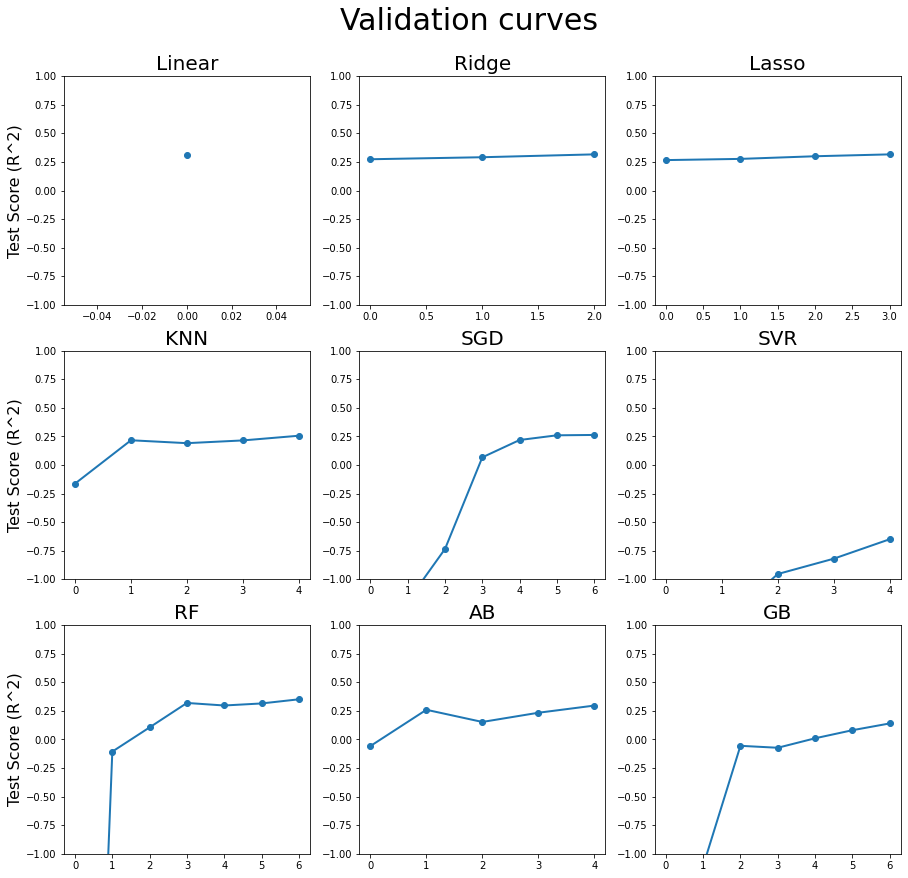

In [55]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 3, figsize=(15, 12))

for i, (name, result) in enumerate(cv_results.items()):
    row, col = i // 3, i % 3
    grouped_by_iter_df = result.groupby('iter').mean()
    iterations = grouped_by_iter_df.index
    test_scores = grouped_by_iter_df['mean_test_score']
    axs[row][col].set_title(name, fontsize=20)
    axs[row][col].set_ylim((-1, 1))
    if col == 0:
        axs[row][col].set_ylabel('Test Score (R^2)', fontsize=16)
    axs[row][col].plot(iterations, test_scores, lw=2, marker='o')

fig.suptitle('Validation curves', fontsize=30)
fig.subplots_adjust(bottom=0, top=0.9)
plt.show()
fig.savefig('../models/full/training/validation_curves.png', bbox_inches='tight')


### Evaluate best models on test set

In [57]:
test_results = {}

for name, result in final_results.items():
    y_pred = result.best_estimator_.predict(X_test)
    test_results[name] = {
        'mae': mean_absolute_error(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': mean_squared_error(y_test, y_pred, squared=False),
        'r2': r2_score(y_test, y_pred)
    }

with open("../models/model_testing_full_results.json", "w") as outfile:
    json.dump(test_results, outfile)